# Data and Sampling Distribution

Note: In general Data Scientist need not worry about the theoretical nature of a population and instead should focus on the sampling procedures and the data at hand. There are some notable exceptions: data that is generated from physical processes can be modeled. For example a coin flip: this follows a binomial distribution. Any real-life binomial situation(buy or don't buy, fraud or no fraud, click or don't click) can be modeled effectively by a coin(with modified probability of landing heads).

## Content
- #### Random Sampling and Sample Bias
- #### Selection Bias
- #### Sampling Distribution of a Statistic
    - Plotting histogram of annual income of loan applicants, mean of 5 applicants, mean of 20 applicants
- #### The Bootstrap
    - Compute boostrap statistics (bias and standard deviation)
- #### Confidence Intervals
- #### Normal Distribution
    - Plotting QQ-Plot of a sample of 100 values drawn from a standard normal distribution
- #### Long-Tailed Distribution
    - Plotting QQ-Plot of the returns for Netflix(NFLX)
- #### Student's t-Distribution
- #### Binomial Distribution
    - Compute binomial PMF and CDF of observing 0 sales in 200 clicks with p = .02
- #### Chi-Square Distribution
- #### F-Distribution
- #### Poisson and Related Distributions
    - Simulationg and plotting poisson distribution
    - Simulationg and plotting exponential distribution
    - Simulationg and plotting weibull distribution



In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
from pathlib import Path
from scipy import stats
from sklearn.utils import resample
import matplotlib.pyplot as plt

%matplotlib inline

In [31]:
try:
    import common
    DATA = common.dataDirectory()
except ImportError:
    DATA = Path().resolve() / 'data'

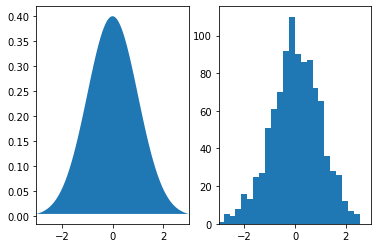

In [32]:
np.random.seed(seed=1)
x = np.linspace(-3, 3, 300)
xsample = stats.norm.rvs(size=1000)

fig, axes = plt.subplots(ncols=2)

ax = axes[0]
ax.fill(x, stats.norm.pdf(x))
ax.set_xlim(-3, 3)

ax = axes[1]
ax.hist(xsample, bins=30)
ax.set_xlim(-3, 3)
ax.set_position

plt.show()

## Random Sampling and Sample Bias

Important key terms: 
- **Random and stratisfied sampling**
- **Population**
- **Bias**
- **Sample bias**

Data quality is often greater than data quantity when making estimates or model based on a sample. In data science this means **completeness, consistency of format, cleaniness, and accuracy of data points**. Statistics add the notion of **representativeness**. Classic example: Literary Digest poll of 1963 that predicted a victory of Alf Landon over Franklin Roosevelt: they polled the subscribers plus additional lists of people, totaling 10 million people. George Gallup biweekly polls of just 2000 people and accuratly predicted a Roosevelt victory. 

A classic scenario when size matter is when the data is not only big but sparse as well. For example search queries recieved by Google. There are over 150,000 words and Google processes trillions of queries a day, leading to a matrices mostly made of zeros.

## Selection Bias

Important key terms: 
- **Selection bias**(cherry picking, time intervals, stopping experiments, regression to the mean)
- **Data snooping** (tossing coin 10 times vs. 20 people tossing coin 10 times)
- **Vast search effect**

In data science, selection bias is something to worry about when you repeatly review a large data set. Using a holdout set or more than one to validate performance.

## Sampling Distribution of a Statistic
Important key terms: 
- **Sample statistic**
- **Data and sample distribution**
- **Central limit theorem**
- **Standard error**(variability of a sample statistic over many statitics)

Note: The distribution of a sample statistic such as the mean is likely to be more regular and bell shaped than the distribution of the data itself.

In [33]:
LOANS_INCOME = DATA / 'loans_income.csv'
SP500 = DATA / 'sp500_data.csv.gz'

### Plotting histogram of annual income of loan applicants, mean of 5 applicants, mean of 20 applicants

In [34]:
loans = pd.read_csv(LOANS_INCOME).squeeze('columns')
loans.head()

0     67000
1     52000
2    100000
3     78762
4     37041
Name: x, dtype: int64

In [35]:
sample_loans = pd.DataFrame({
    'income': loans.sample(1000),
    'type': 'Data',
})
sample_loans_5 = pd.DataFrame({
    'income': [loans.sample(5).mean() for _ in range(1000)],
    'type': 'Mean of 5'
})
sample_loans_20 = pd.DataFrame({
    'income': [loans.sample(20).mean() for _ in range(1000)],
    'type': 'Mean of 20'
})

results = pd.concat([sample_loans, sample_loans_5, sample_loans_20])
results.head()

,income,type
40292,63000.0,Data
38959,92000.0,Data
17361,134000.0,Data
33996,52000.0,Data
26491,43000.0,Data


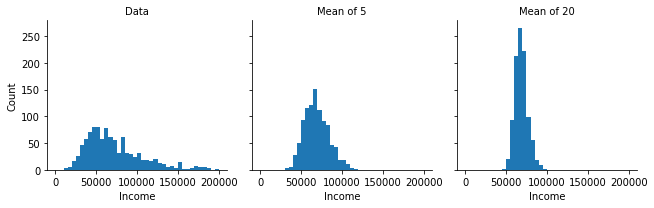

In [36]:
g = sns.FacetGrid(results, col='type')
g.map(plt.hist, 'income', range=[0,200000], bins=40)
g.set_axis_labels('Income', 'Count')
g.set_titles('{col_name}')

plt.show()

Note that frequency distributions of a sample statistic tells us how that metric would turn out differently from sample to sample and can be estimated via the boostrap, or via formulas that rely on the central limit theorem. A key metric that sums up the variability of a sample statistic is its standard error.

## The Bootstrap
Important key terms: 
- **Bootstrap sample**
- **Resampling**

The algorithm for a bootstrap resampling of the mean, for sample size n we have
1. Draw a sample value, record it, and then replace it.
2. Repeat n times
3. Record the mean of the n resampled values
4. Repeat 1-3 R times(R the number of iterations)
5. Use the R results to:
    - Calculate their standard deviation(which estimates sample mean standard error)
    - Produce a histogram or boxplot
    - Find a confidence interval


### Compute boostrap statistics (bias and standard deviation)

In [37]:
results = []
for iteration in range(1000):
    sample = resample(loans)
    results.append(sample.median())
results = pd.Series(results)
print('Bootstrap Statistics:')
print('original: {}'.format(loans.median()))
print('bias: {}'.format(results.mean()-loans.median()))
print('std. err: {}'.format(results.std()))

Bootstrap Statistics:
original: 62000.0
bias: -82.09799999999814
std. err: 228.73933106830927


The original estimate of the median is $62000. The bootstrap distribution indicates that the estimate has a bias of about -$80 and a standard error of $220. The results will vary slightly between consecutive runs of the algorithm.

Note: we can run boostrapping on multivariate data. A model might then be run on the bootstrapped data, for example, to estimate the stability(vaiability) of model parameters, or to improve predictive power. With classification and regression trees, running multiple trees on bootstrap samples and then averaging their predictions or with classification, taking the majority vote, generally performs better than using a single tree. This process is called bagging.

## Confidence Intervals
Important key terms: 
- **Confidence level**
- **Interval endpoints**

A x% confidence interval around a sample estimate should, on average, contian similar sample estimates x% of the time( when similar sampling procedur is followed). Given a sample size n, and a sample statistic of intrest, the algorithm for a bootstrap confidence interval is as follows:
1. Draw a random sample of size n with replacement from the data(a resample)
2. Record the statistic of interest for the resample
3. Repeat steps 1-2 many(R) times
4. For an x% confidence interval, trim $[(100-x)/2]$% of the R resample results from either end of the distribution
5. The trim points are the endpoints of an x% bootstrap confidence interval.

The bootstrap is a general tool that can be used to generate confidence intervals for most statistics, or model parameters. For a Data Scientist the confidence interval is a tool that can be used to get an idea of how variable a sample result might be, most likely to communicate the potential error in an estimate, and perhaps to learn whether a larger sample is needed.

## Normal Distribution
Important key terms:
- **Error**
- **Standardize**
- **z-score**
- **Standard normal**
- **QQ-plot**

Recall the 68,95,99 rule.

### Plotting QQ-Plot of a sample of 100 values drawn from a standard normal distribution

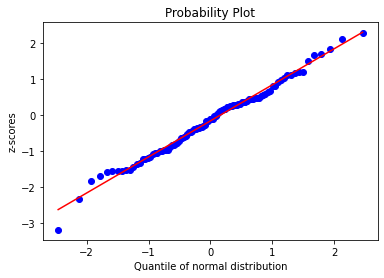

In [38]:
fig, ax = plt.subplots()
norm_sample = stats.norm.rvs(size=100)
stats.probplot(norm_sample, plot=ax)
ax.set_ylabel('z-scores')
ax.set_xlabel('Quantile of normal distribution')
plt.show()

## Long-Tailed Distribution
Important key terms:
- **Tail**
- **Skew**

Note that historically data is generally not normally distributed, which are useful with respect to errors and sample statistics. 

In [39]:
sp500 = pd.read_csv(SP500)
sp500.head()

,Unnamed: 0,ADS,CA,MSFT,RHT,CTSH,CSC,EMC,IBM,XRX,...,WAT,ALXN,AMGN,BXLT,BIIB,CELG,GILD,REGN,VRTX,HSIC
0,1993-01-29,0.0,0.060124,-0.022100,0.0,0.0,0.018897,0.007368,0.092165,0.259140,...,0.0,0.0,0.34716,0.0,0.04167,0.00000,0.015564,1.75,0.1250,0.0
1,1993-02-01,0.0,-0.180389,0.027621,0.0,0.0,0.018889,0.018425,0.115207,-0.100775,...,0.0,0.0,-0.23144,0.0,0.00000,-0.01041,0.007782,1.25,0.1250,0.0
2,1993-02-02,0.0,-0.120257,0.035900,0.0,0.0,-0.075573,0.029482,-0.023041,0.028796,...,0.0,0.0,-0.11572,0.0,0.00000,0.00000,-0.007792,-0.25,0.0000,0.0
3,1993-02-03,0.0,0.060124,-0.024857,0.0,0.0,-0.151128,0.003689,-0.253454,-0.043190,...,0.0,0.0,-0.08679,0.0,0.04167,-0.04167,-0.038919,-0.50,0.0625,0.0
4,1993-02-04,0.0,-0.360770,-0.060757,0.0,0.0,0.113350,-0.022114,0.069862,0.000000,...,0.0,0.0,0.14465,0.0,-0.04166,-0.03126,-0.046711,0.00,0.0625,0.0


### Plotting QQ-Plot of the returns for Netflix(NFLX)

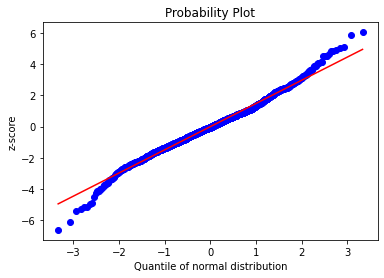

In [40]:
nflx = sp500.NFLX

# If we want to model returns using the normal distribution!
# - SIMPLE RETURNS: The product of normally distributed variables is NOT normally distributed
# - LOG RETURNS: The sum of normally distributed variables DOES follow a normal distribution
# Also the log distribution bounds our stock price at 0. Which is a nice property to have and is consistent with reality.

nflx = np.diff(np.log(nflx[nflx>0]))
fig, ax = plt.subplots()
stats.probplot(nflx, plot=ax)
ax.set_xlabel('Quantile of normal distribution')
ax.set_ylabel('z-score')
plt.show()

Note: in contrast to normal distribution QQ-Plot the points above are for below the line for low values and far above the line for high values, indicating the data are not normally distributed. This means we are much more likely to observe extreme values than would be expected if the data had a normal distribution.

## Student's t-Distribution
Important key terms:
- **Degrees of freedom**

Note: t-distribution is normally shape but is also thicker and longer on the tails. Used a lot in sample statistics, like the sample mean.

Also, t-distribution is used in classical statistical inference but is not central to the purpose of data science. Empirical bootstrap sampling can answer most questions about sampling error. On the other hand, data scientist can encounter t-statistics in output from statitistic software, for example in A/B tests and regressions.

## Binomial Distribution
Important key terms:
- **Trial**
- **Success**
- **Binomial**
- **Binomial trial**
- **Binomial distribution**

Binomial distribution would answer a question like: If the probability of a click converting to a sale is .02, what is the probability of observing 0 sales in 200 clicks?

Note that calculating binomial probabilities with large sample sized and probability not too close to 0 or 1 most statistical procedures use the normal distribution with mean and variance, as an approximation.

### Compute binomial PMF and CDF of observing 0 sales in 200 clicks with p = .02

In [41]:
stats.binom.pmf(0, n=200, p=.02)

0.01758794660572155

In [42]:
stats.binom.cdf(0, n=200, p=.02)

0.0175879466057215

## Chi-Square Distribution
Say you want to test whether one variable(say 'gender') is independent of another(say 'was promoted in job') and you have the counts of the number in each of the cells of the data table. The statistic that measures the extent of which results depart from the null expectation of independence is the chi-square statistic. It's the difference between the observed and expected values, divided by the square root of the expected value, squared, then summed across all categories. A low chi-square value for a set of counts indicates that they closely follow the expected distribution

## F-Distribution
Much like the chi-square distribution we are dealing with multiple treatments across groups. In this case we are interested in the extent to which differences among group means are greater than we might expect under normal random variation. The F-statistic measures this and is the ratio of the variablility amoung the group  means to the variability within each group. This comparison is termed an analysis of variance (ANOVA). The F-statistic is also used in linear regression to compare the variation accounted for by the regression model to the overall variation in the data.

## Poisson and Related Distributions
Important key terms:
- **Lambda**
- **Poisson distribution**
- **Exponential distribution**
- **Weibull distribution**

### Simulationg and plotting poisson distribution

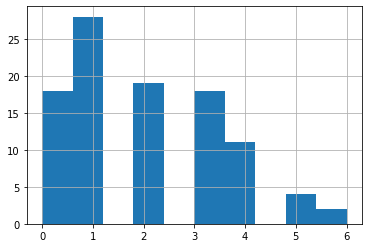

In [49]:
poisson_sample = stats.poisson.rvs(2, size=100)
pd.Series(poisson_sample).hist()
plt.show()

### Simulationg and plotting exponential distribution

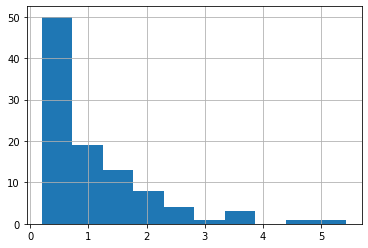

In [46]:
exponential_sample = stats.expon.rvs(.2, size=100)
pd.Series(exponential_sample).hist()
plt.show()

### Simulationg and plotting weibull distribution

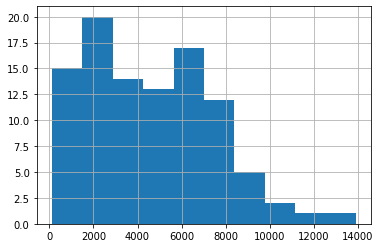

In [47]:
weibull_sample = stats.weibull_min.rvs(1.5, scale=5000, size=100)
pd.Series(weibull_sample).hist()
plt.show()